In [87]:
from copy import deepcopy
import gym
import gym_wordle
import torch
from gym_wordle.exceptions import InvalidWordException
from actor_critic.a2c import ActorCriticNet
from agents.prob_agent import ProbabilisticAgent
from agents.random_agent import RandomAgent
from utils import load_model
from utils.const import STATE_SIZE
from utils.utils import load_word_list, convert_encoded_array_to_human_readable
from agents import GreedyAgent
from tqdm import tqdm
from plots.entropy.simulations import run_trial_entropy, get_entropies_of_all_words
import matplotlib.pyplot as plt

In [88]:


def run_trial(a2c_agent, verbose, word_list):
    env = gym.make('Wordle-v0')
    games = []
    num_turns_distribution = [0 for _ in range(6)]
    num_wins = 0
    total_steps = 0
    for index in tqdm(range(len(word_list))):
        i = word_list[index]
        obs = env.reset()
        env.hidden_word = [ord(x) - 97 for x in i]
        done = False
        step = 0


        actions = []
        while not done:
            while True:
                try:
                    action, log_prob_action, entropy, state_value = a2c_agent(torch.Tensor(obs))
                    actions.append(convert_encoded_array_to_human_readable(action))

                    obs, reward, done, _ = env.step(action)
                    step += 1

                    break
                except InvalidWordException:
                    pass

        if(action == list(env.hidden_word)):
            num_wins += 1
            num_turns_distribution[step - 1] += 1
            total_steps += step

        games.append((deepcopy(actions), convert_encoded_array_to_human_readable(env.hidden_word)))

    # print(f"WIN RATE: {num_wins / NUM_ITER}")
    if(verbose):
        for game in games:
            print(str(game))

    return num_wins / len(word_list), num_turns_distribution, total_steps / num_wins if num_wins > 0 else 0, games

In [89]:

WORDS_DIR = "./gym-wordle/gym_wordle/data/5_words.txt"
SOLUTIONS_DIR = "./plots/entropy/possible_words.txt"
EMBEDDING_SIZE = 64

word_list = load_word_list(WORDS_DIR)
allowed_solutions = load_word_list(SOLUTIONS_DIR)

In [90]:
def get_optimal_agent_data(num_iter = 1000):
    model = ActorCriticNet(STATE_SIZE, word_list, EMBEDDING_SIZE)
    load_model(model, "reinforce15k")
    optimal_agent_no_solution_knowledge = ProbabilisticAgent(model, word_list)

    win_rates = []
    turn_distributions = []
    averages_amount_of_turns = []

    for _ in range(num_iter):
        win_rate, turn_distribution, average_amount_of_turns, _ = run_trial(optimal_agent_no_solution_knowledge, False, allowed_solutions)
        win_rates.append(win_rate)
        turn_distributions.append(turn_distribution)
        averages_amount_of_turns.append(average_amount_of_turns)
    

    return win_rates, turn_distributions, averages_amount_of_turns

In [91]:
def get_random_agent_data(num_iter = 1000):
    random_agent = RandomAgent(word_list)

    win_rates = []
    turn_distributions = []
    averages_amount_of_turns = []

    for _ in range(num_iter):
        win_rate, turn_distribution, average_amount_of_turns, _ = run_trial(random_agent, False, allowed_solutions)
        win_rates.append(win_rate)
        turn_distributions.append(turn_distribution)
        averages_amount_of_turns.append(average_amount_of_turns)
    

    return win_rates, turn_distributions, averages_amount_of_turns

In [92]:

import numpy as np
def get_entropy_agent_data(first_guess, num_iter = 1000):
    win_rates = []
    turn_distributions = []
    averages_amount_of_turns = []

    for _ in range(num_iter):
        turn_distribution, average_amount_of_turns, _ = run_trial_entropy(first_guess=first_guess)
        win_rate = 1.0
        if(len(turn_distribution) > 6):
            losses = np.sum(turn_distribution[6:])
            win_rate = losses / np.sum(turn_distribution)
        
        win_rates.append(win_rate)
        turn_distributions.append(turn_distribution)
        averages_amount_of_turns.append(average_amount_of_turns)
    
    return win_rates, turn_distributions, averages_amount_of_turns

In [93]:
NUM_ITER = 10

In [94]:
opt_win_rates, opt_turn_distributions, opt_averages_amount_of_turns = get_optimal_agent_data(num_iter=NUM_ITER)

100%|██████████| 2309/2309 [00:53<00:00, 43.28it/s]


In [95]:
rand_win_rates, rand_turn_distributions, rand_averages_amount_of_turns = get_random_agent_data(num_iter=NUM_ITER)

100%|██████████| 2309/2309 [00:01<00:00, 1524.92it/s]


In [96]:
salet_win_rates, salet_turn_distributions, salet_averages_amount_of_turns = get_entropy_agent_data("salet", num_iter=NUM_ITER)

In [97]:
crate_win_rates, crate_turn_distributions, crate_averages_amount_of_turns = get_entropy_agent_data("salet", num_iter=NUM_ITER)

In [98]:
trace_win_rates, trace_turn_distributions, trace_averages_amount_of_turns = get_entropy_agent_data("salet", num_iter=NUM_ITER)

In [99]:
agent_names = ['REINFORCE Agent', "Random Agent", "Entropy Agent (SALET)", "Entropy Agent (CRATE)", "Entropy Agent (TRACE)"]

print(rand_win_rates)
means = np.mean([opt_win_rates, rand_win_rates, salet_win_rates, crate_win_rates, trace_win_rates], axis = 1)
std_devs = np.std([opt_win_rates, rand_win_rates, salet_win_rates, crate_win_rates, trace_win_rates], axis = 1)

[0.0, 0.0008661758336942399, 0.0, 0.0, 0.00043308791684711995, 0.0, 0.00043308791684711995, 0.0, 0.00043308791684711995, 0.00043308791684711995]


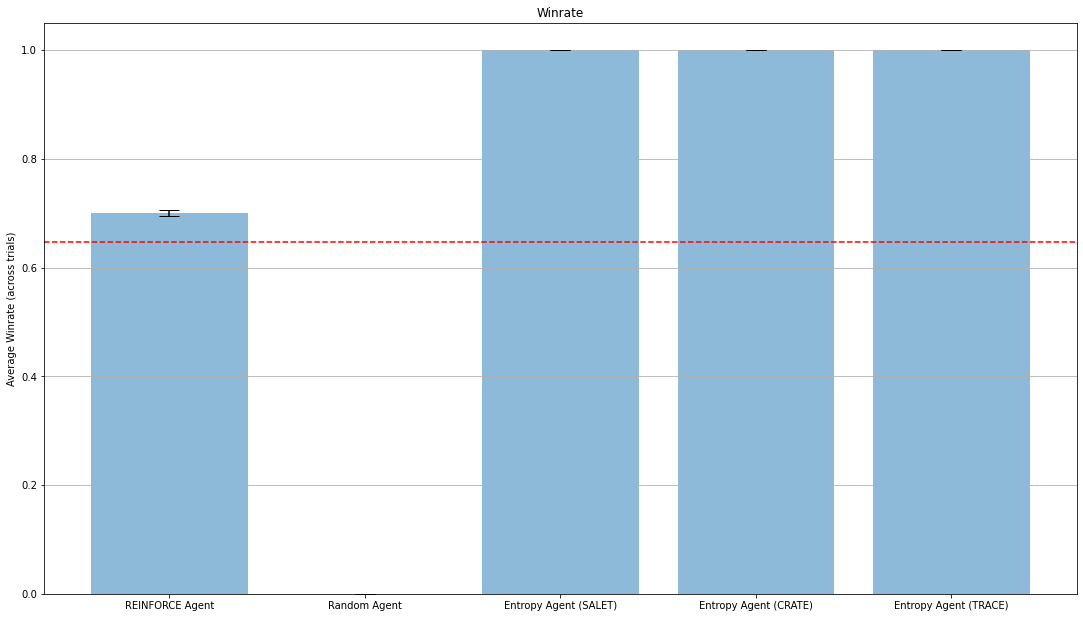

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.bar(np.arange(len(agent_names)), means, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Winrate (across trials)')
ax.set_xticks(np.arange(len(agent_names)))
ax.set_xticklabels(agent_names)
ax.set_title('Winrate')
ax.yaxis.grid(True)

plt.axhline(.648, color='red', linestyle = '--')

# Save the figure and show
plt.show()

In [100]:
agent_names = ['REINFORCE Agent', "Random Agent", "Entropy Agent (SALET)", "Entropy Agent (CRATE)", "Entropy Agent (TRACE)"]
means2 = np.mean([opt_averages_amount_of_turns, rand_averages_amount_of_turns, salet_averages_amount_of_turns, crate_averages_amount_of_turns, trace_averages_amount_of_turns], axis = 1)
std_devs2 = np.std([opt_averages_amount_of_turns, rand_averages_amount_of_turns, salet_averages_amount_of_turns, crate_averages_amount_of_turns, trace_averages_amount_of_turns], axis = 1)

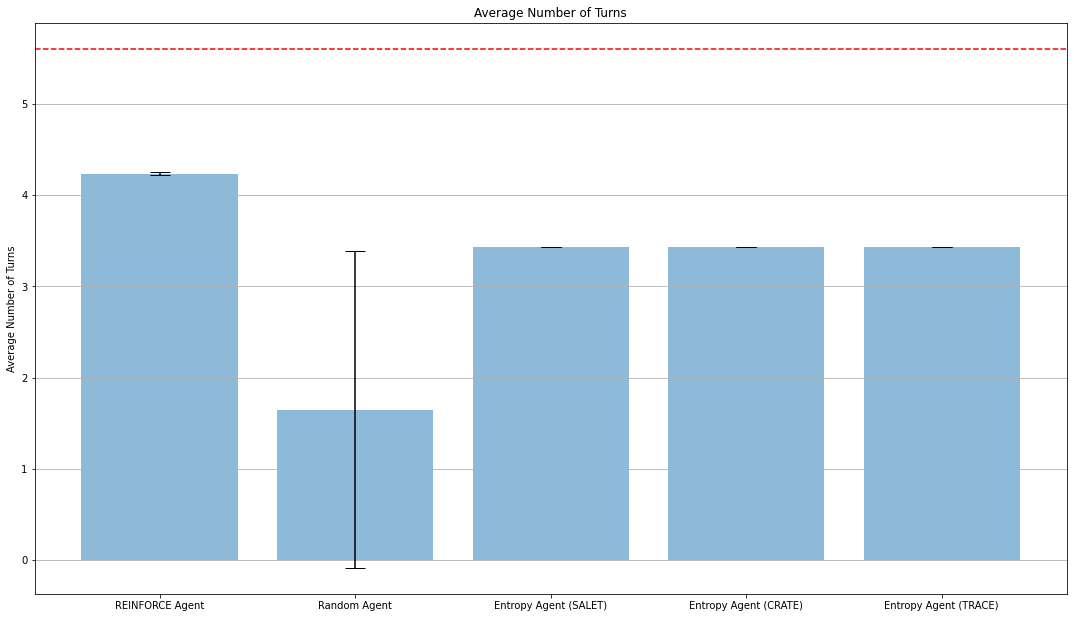

In [101]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.bar(np.arange(len(agent_names)), means2, yerr=std_devs2, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Number of Turns')
ax.set_xticks(np.arange(len(agent_names)))
ax.set_xticklabels(agent_names)
ax.set_title('Average Number of Turns')
ax.yaxis.grid(True)

plt.axhline(5.6, color='red', linestyle = '--')

# Save the figure and show
plt.show()